We are using the Cifar 10 dataset. The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes present are:


* airplane										
* automobile										
* bird										
* cat										
* deer										
* dog										
* frog										
* horse										
* ship										
* truck

https://www.cs.toronto.edu/~kriz/cifar.html

We will see throughout the notebook that the complexity of the dataset disallows for clustering of the dataset through either kmeans or gmm clustering. The Neural network based solution has a better result here

*   Importing all the necessary Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.preprocessing import StandardScaler

In [3]:
import tqdm

In [4]:
from sklearn.cluster import KMeans

In [29]:
from sklearn.metrics import silhouette_score, silhouette_samples
import tensorflow as tf
from tensorflow import keras

*   Loading the Dataset and splitting Train and Test

In [6]:
import cv2
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert the images to grayscale
x_train_gray = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2]), dtype=np.float32)
x_test_gray = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2]), dtype=np.float32)

for i in range(x_train.shape[0]):
    x_train_gray[i] = cv2.cvtColor(x_train[i], cv2.COLOR_RGB2GRAY)

for i in range(x_test.shape[0]):
    x_test_gray[i] = cv2.cvtColor(x_test[i], cv2.COLOR_RGB2GRAY)

170498071/170498071 [==============================] - 4s 0us/step


In [7]:
x_train_gray.shape

(50000, 32, 32)

In [8]:
train_images = x_train_gray.reshape(50000,-1)/255

In [9]:
train_images.shape

(50000, 1024)

In [10]:
test_images = x_test_gray.reshape(10000, -1)/255

In [11]:
test_images.shape

(10000, 1024)

In [12]:
y_train.flatten().shape

(50000,)

In [13]:
train_labels = y_train.flatten()
test_labels = y_test.flatten()

*   Splitting the training data into training data and validation data

In [14]:
trainX, valX, trainY, valY = train_test_split(train_images,train_labels, test_size = 1/5, random_state = 42 )

In [15]:
trainX.shape

(40000, 1024)

In [16]:
valX.shape

(10000, 1024)

In [17]:
test_images.shape

(10000, 1024)

In [18]:
trainY.shape

(40000,)

In [ ]:
class_names = ["airplane",										
"automobile",										
"bird",										
"cat",										
"deer",										
"dog",										
"frog",										
"horse",										
"ship",										
"truck"]

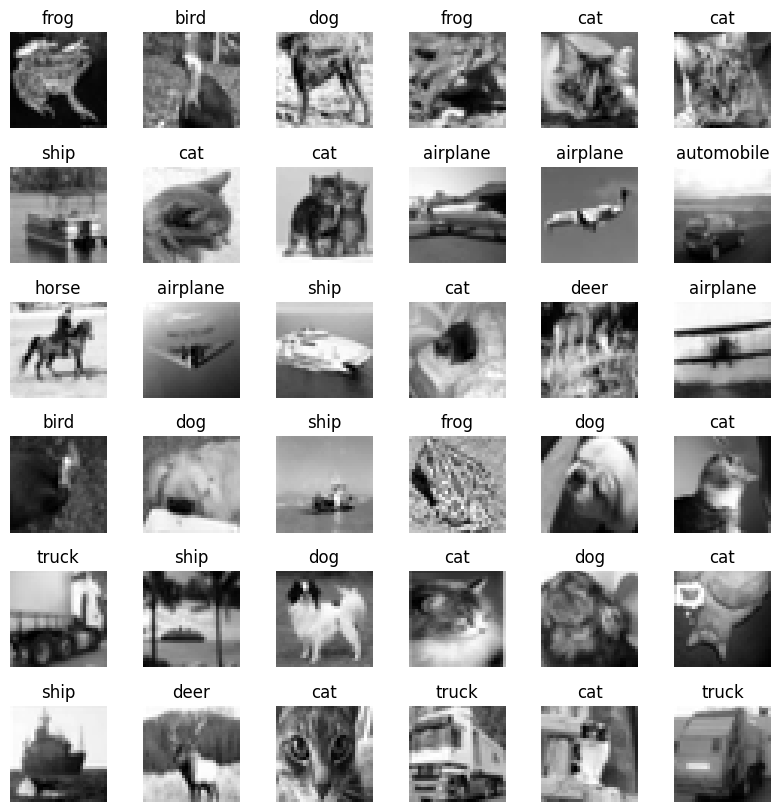

In [ ]:


# Define a function to display a grid of images
def plot_images(images, labels,sz=32):
    fig, axes = plt.subplots(6, 6, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(36):
        axes[i].imshow(images[i].reshape(sz, sz), cmap="gray")
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

plot_images(trainX, trainY)




---


**Apply PCA to the training portion of the dataset. How many components do you need to preserve 95% of the variance?**


---


In [19]:
pca = PCA()
pca.fit(train_images)

# Calculate the explained variance ratio for each PC
variance_ratio = pca.explained_variance_ratio_

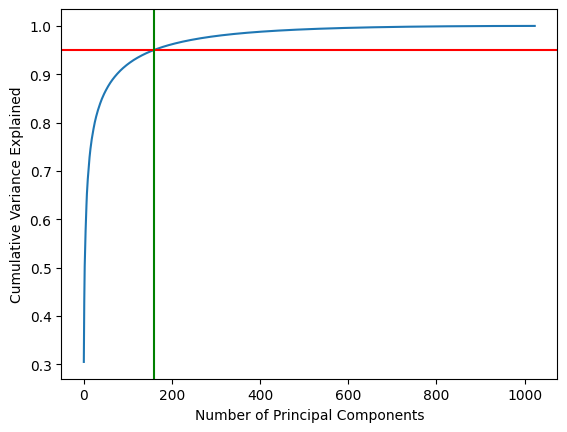

In [20]:
# Plot the scree plot
plt.plot(np.cumsum(variance_ratio))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')


# Add a line at 95%
plt.axhline(y=0.95, color='r', linestyle='-')
cumulative_var = np.cumsum(variance_ratio)
idx = np.argmax(cumulative_var >= 0.95)
plt.axvline(x=idx, color='g', linestyle='-')

plt.show()


In [21]:
cumulative_variance_ratio = np.cumsum(variance_ratio)
components = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
print(components)

160


*   The intersecting lines from the graph, and the above executed equation brings us to conclude that we need 160 features to explain 95% of the data variability



---


**Train a Random Forest classifier on the reduced dataset. Was training much faster than in Homework 2? Evaluate the classifier on the test set. How does it compare to the classifier from Homework 2?**


---




*   Random forest on initial dataset

In [ ]:
import time

start=time.time()

rf = RandomForestClassifier()
rf.fit(trainX,trainY)

end=time.time()
print(end-start)

<ipython-input-31-ffe0f1774d8b>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(trainX,trainY)


141.64525985717773


*   Applying random forest on initial dataset takes around 141 seconds to train the data, the accuracy of this model on test set can be given by:

In [ ]:
test_pred = rf.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_pred)

In [ ]:
test_accuracy

0.4144

*   Applying random forest on reduced dimensional data (PCA Data)

In [22]:
pca = PCA(n_components=160)
# Fit the PCA model to the data
pca.fit(train_images)
train_pca_X = pca.transform(train_images)

In [23]:
test_pca_X = pca.transform(test_images)

In [24]:
train_pca_X.shape

(50000, 160)

In [25]:
test_pca_X.shape

(10000, 160)

In [26]:
trainX, valX, trainY, valY = train_test_split(train_pca_X,train_labels,test_size = 1/5,random_state = 42)


In [ ]:
start=time.time()

rf.fit(trainX,trainY)

end=time.time()

print(end-start)

93.86677360534668


*   Applying random forest on reduced dimensional dataset or PCA applied dataset takes around 94 seconds to train the data, the accuracy of this model on test set can be given by:

In [ ]:
test_pred = rf.predict(test_pca_X)
test_accuracy = accuracy_score(test_labels, test_pred)

In [ ]:
test_accuracy

0.37

**The random forest trained on the initial dataset took longer to train but achieved higher accuracy than the random forest trained on reduced-dimensional data using PCA.

The initial dataset likely has a larger number of features, which makes it more complex and time-consuming to train a model. However, having more features can also provide the model with more information to learn from and potentially lead to higher accuracy.

In contrast, the reduced-dimensional data generated by PCA has fewer features, which reduces the complexity of the model and can make it faster to train. However, the reduction in the number of features may also result in the loss of important information, which can negatively impact the accuracy of the model.**
 

Based on our evaluations on test data, we find that accuracy of non reduced data is more than reduced dimensional data, because of loss of information.



---


**Plot 10 random images in the original form (without PCA) and then plot them after you kept 95% of variance using PCA.**


---





*   To display 10 random images of original form we used the inverse transform, that restores the training data

In [ ]:
Reformed_train = pca.inverse_transform(train_pca_X)

*   Displaying normal images

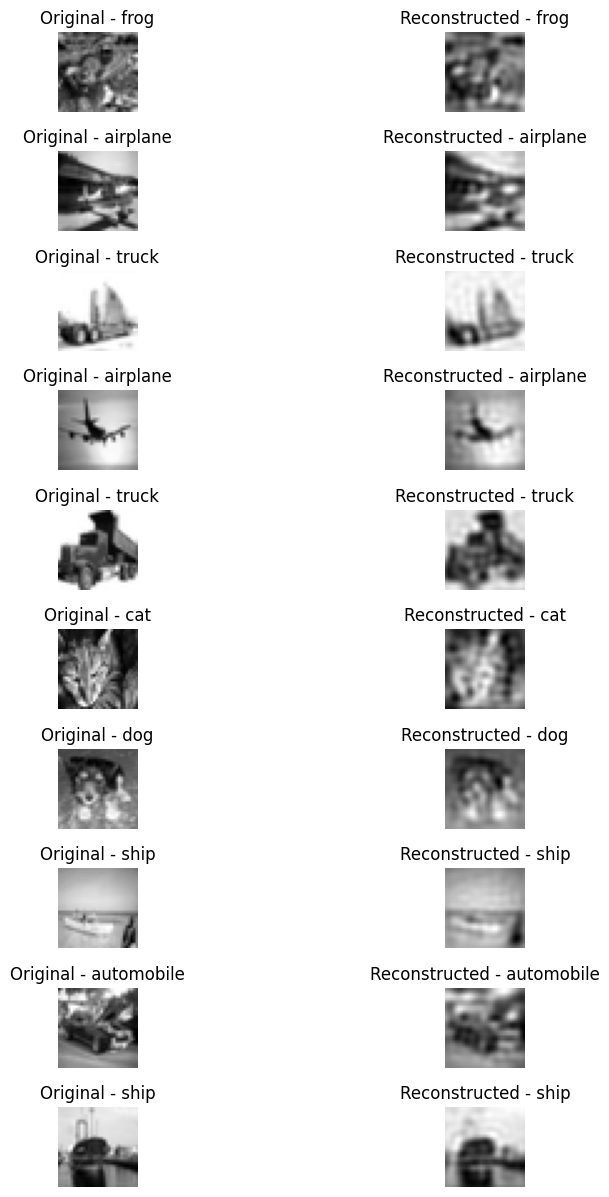

In [ ]:
# Define a function to display a grid of images
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
def plot_images(images, pca_images, labels,sz=32):
    indices = random.sample(range(0, len(images)), 10)
    fig, axes = plt.subplots(10, 2, figsize=(15, 15))
    
    index = 0
    for i,idx in enumerate(indices):
        axes[i][0].imshow(images[idx].reshape(sz, sz), cmap="gray")
        axes[i][0].set_title("Original - " +  class_names[labels[idx]])
        axes[i][0].axis("off")

        axes[i][1].imshow(pca_images[idx].reshape(sz, sz), cmap="gray")
        axes[i][1].set_title("Reconstructed - " + class_names[labels[idx]])
        axes[i][1].axis("off") 

    plt.subplots_adjust(hspace=0.5,wspace=-0.5)
    plt.show()

plot_images(train_images, Reformed_train, train_labels)





---


**How much of the variance is explained with the first two principal components?**


---




In [ ]:
n_components = 2
pca = PCA(n_components=n_components)

# Fit PCA to the data
pca.fit(train_images)

# Calculate the percentage of variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

In [ ]:
print("Explained variability by 2 components is:",sum(explained_variance_ratio))

Explained variability by 2 components is: 0.4294559210538864




*   This says that the total variation in data attributed by both components sums up to around 43%







---


**Use PCA to reduce dimensionality to only 2 dimensions. Plot 1000 random images from the training set in the 2D space spanned by the first two principal components. Use a scatterplot with 10 different colors to represent each image’s target class.**


---



In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_images)



*   Plot of random images from training set in 2d space



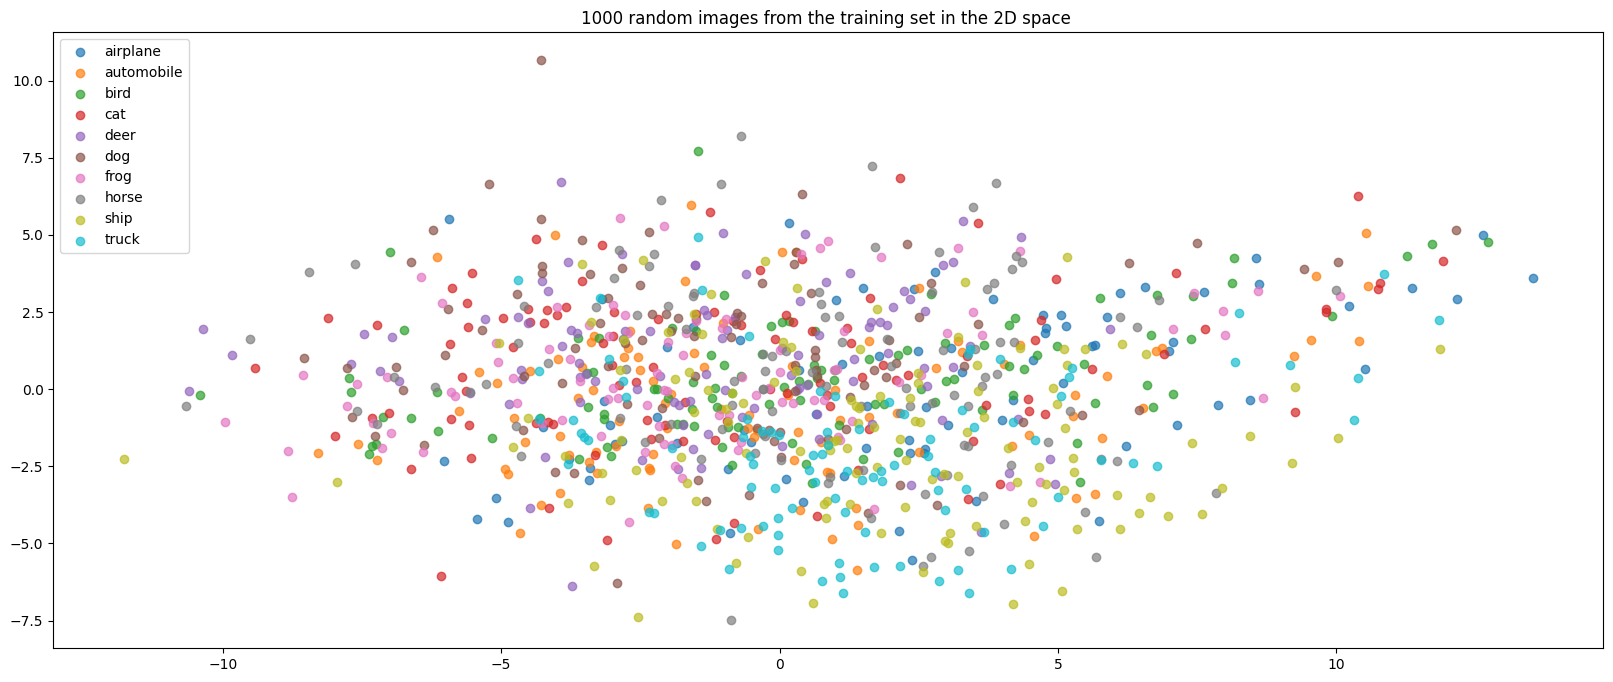

In [ ]:
indices = np.random.choice(train_images.shape[0], 1000, replace=False)
X_pca_1000 = X_pca[indices]
Y_pca_1000 = train_labels[indices]
# Create a color map for the 10 target classes
color_map = plt.get_cmap('tab10')

# Plot the 2D projection with colored points for each target class
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.scatter(X_pca_1000[Y_pca_1000 == i, 0],
                X_pca_1000[Y_pca_1000 == i, 1],
                color=color_map(i),
                label=str(i),
                alpha=0.7)
plt.legend(class_names.values())
plt.title('1000 random images from the training set in the 2D space ')
plt.show()

In [ ]:
trainX.shape

(40000, 160)

---

Repeat the process and create the same type of plots for t-SNE, LLE and MDS. Which of the visualizations do you prefer and why?

---

---

*   Plot of images from training set in 2d space using T-sne

---

In [ ]:



tsne = TSNE(n_components=2, perplexity = 50)
tsne.fit(trainX)



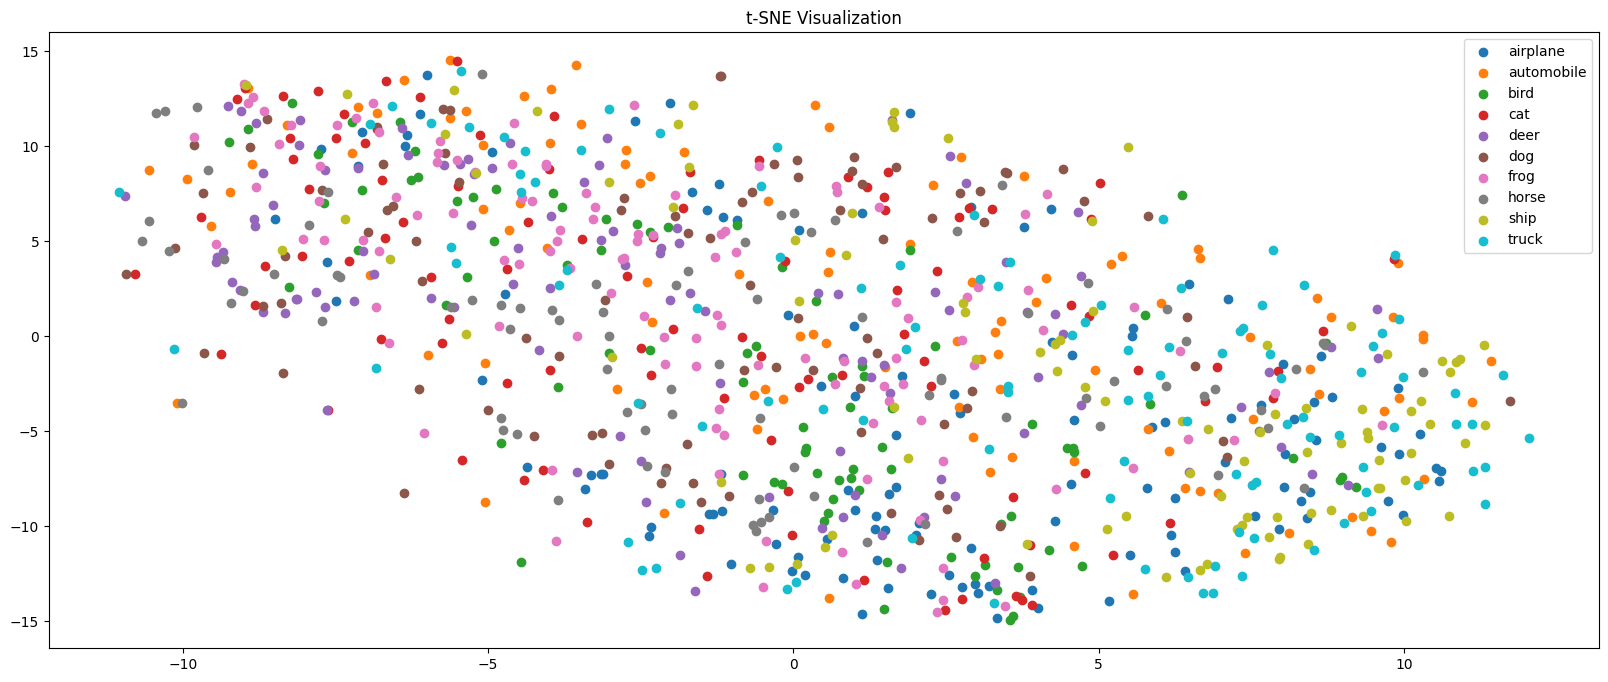

In [ ]:
indices = np.random.choice(trainX.shape[0], 1000, replace=False)
X_tsne_1000 = trainX[indices]
X_tsne_1000 = tsne.fit_transform(X_tsne_1000)
Y_tsne_1000 = trainY[indices]




plt.figure(figsize=(20, 8))
for target in range(10):
    plt.scatter(X_tsne_1000[Y_tsne_1000 == target, 0], X_tsne_1000[Y_tsne_1000 == target, 1], label=target)
plt.legend(class_names.values())
plt.title('t-SNE Visualization')
plt.show()

Text(0.5, 0.92, 'T-SNE')

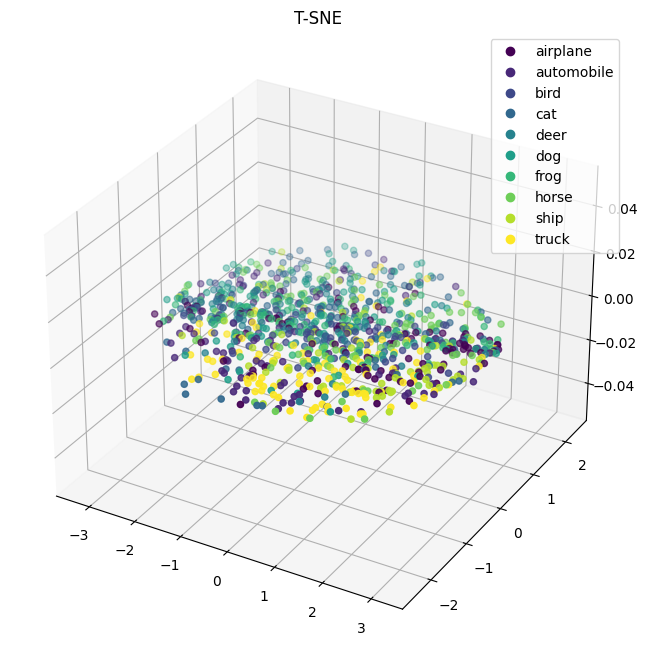

In [ ]:
tsne = TSNE(n_components=2, perplexity = 500)
train_tsne = train_images[indices]
X_tsne = tsne.fit_transform(train_tsne)
X_tsne_1000 = X_tsne
Y_tsne_1000 = train_labels[indices]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
axs = ax.scatter(X_tsne_1000[:,0],X_tsne_1000[:,1],c=Y_tsne_1000,label=class_names)
plt.legend(handles=axs.legend_elements()[0], labels=class_names.values())
plt.title("T-SNE")




---
3D representation of the TSNE data
---

---

*   Plot of training set in 2d space using LLE

---

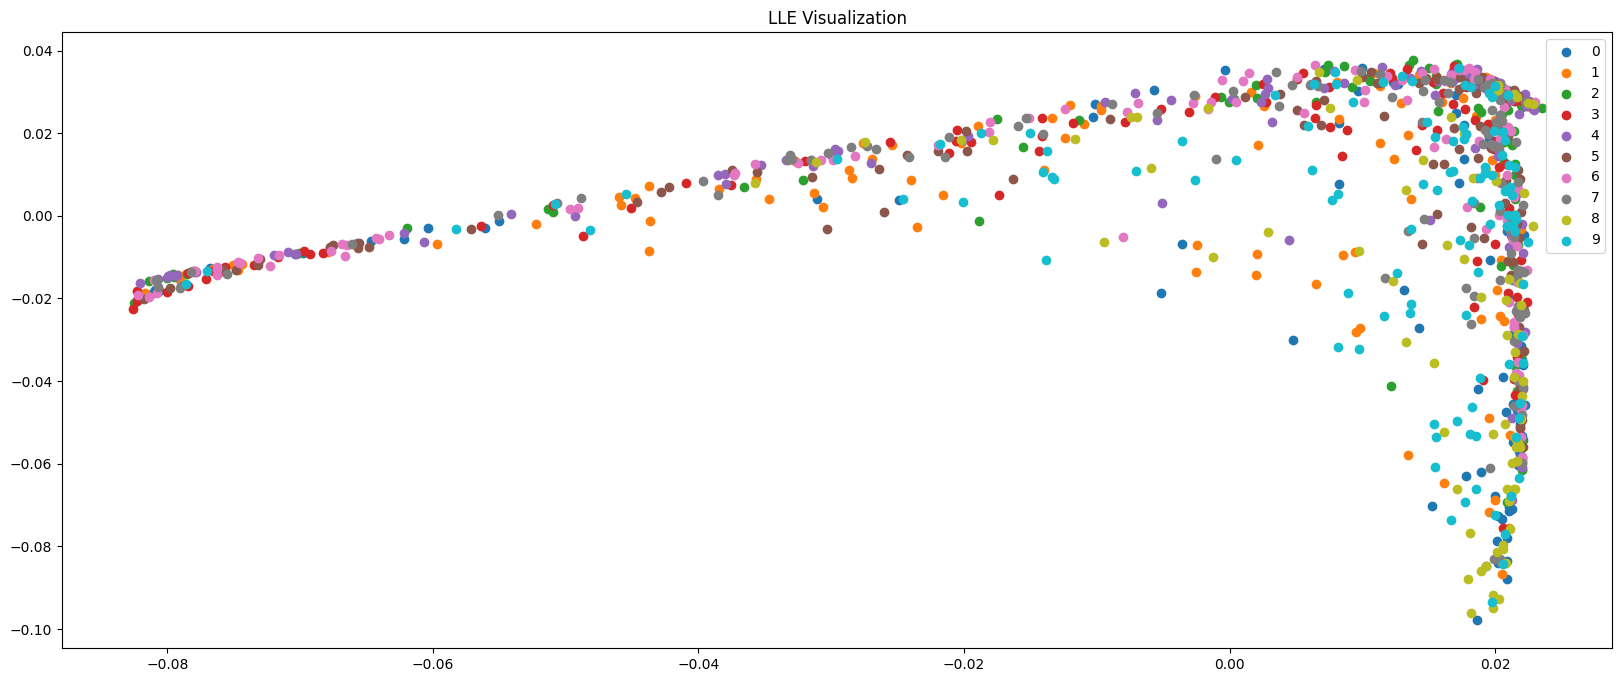

In [ ]:
lle = LocallyLinearEmbedding(n_components=2)
indices = np.random.choice(trainX.shape[0], 1000, replace=False)

X_lle = lle.fit(trainX)
train_lle = train_images[indices]
X_lle_1000 = lle.transform(train_lle) 
Y_lle_1000 = train_labels[indices]




# Plot the LLE visualization
plt.figure(figsize=(20, 8))
for target in range(10):
    plt.scatter(X_lle_1000[Y_lle_1000 == target, 0], X_lle_1000[Y_lle_1000 == target, 1], label=target)
plt.legend(class_names)
plt.title('LLE Visualization')
plt.show()



---

*   Plot of training set in 2d space using MDS

---

In [ ]:
indices = np.random.choice(train_images.shape[0], 5000, replace=False)
mds = MDS(n_components=2)
train_mds = train_images[indices]
X_mds = mds.fit(train_mds)


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


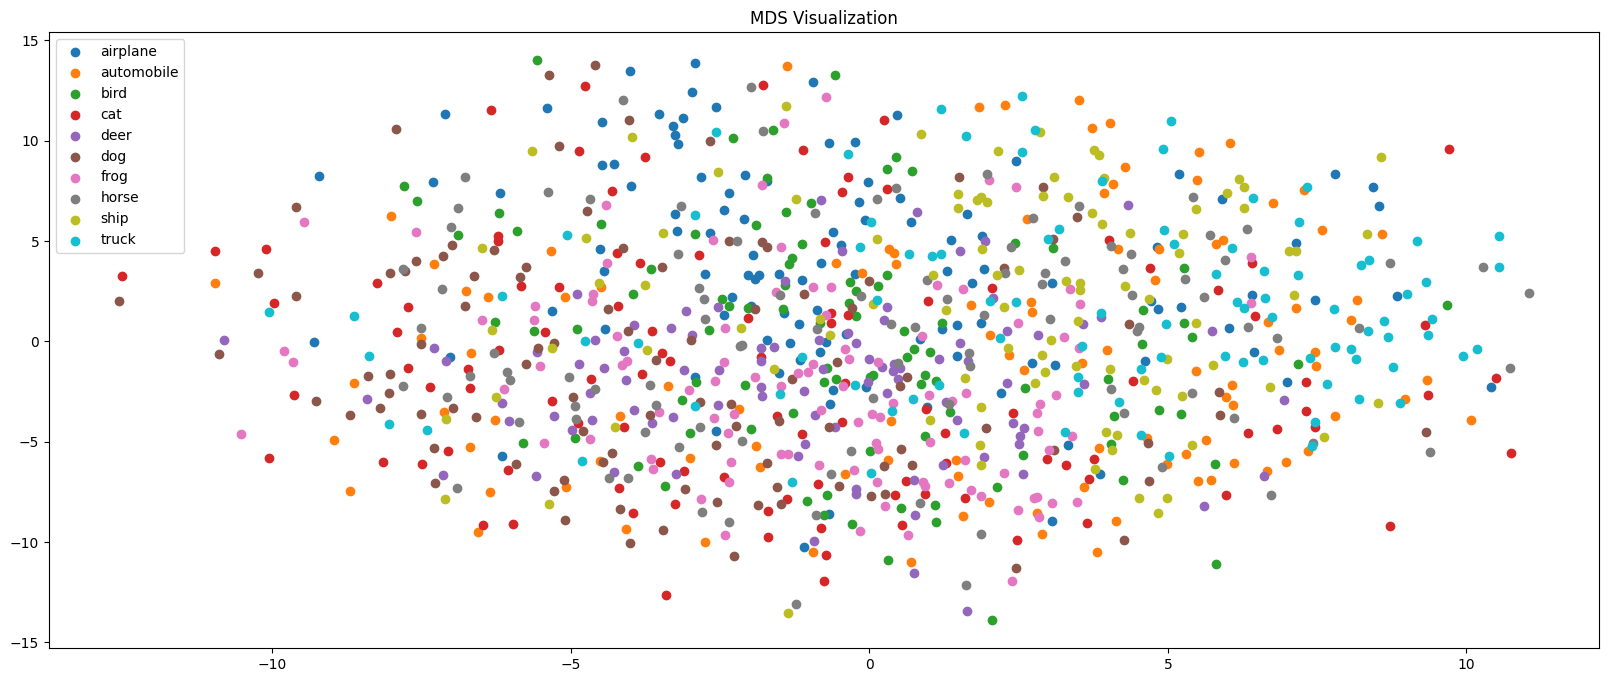

In [ ]:
indices = np.random.choice(train_images.shape[0], 1000, replace=False)
X_mds_1000 = train_images[indices]
X_mds_1000 = mds.fit_transform(X_mds_1000) 
Y_mds_1000 = train_labels[indices]


# Plot the MDS visualization
plt.figure(figsize=(20, 8))
for target in range(10):
    plt.scatter(X_mds_1000[Y_mds_1000 == target, 0], X_mds_1000[Y_mds_1000 == target, 1], label=target)
plt.legend(class_names.values())
plt.title('MDS Visualization')
plt.show()

---
Which of the visualizations do you prefer and why?
---

 
*   From the above graphs we can say that none of the visualizations are particularly good at segregating the data. This could be because the CIFAR-10 dataset is a complex dataset with 10 classes, and it is challenging to find a low-dimensional representation that separates the classes well. In addition, t-SNE, and MDS are nonlinear methods that aim to preserve the distances between points in the high-dimensional space, but they do not necessarily preserve the relationships between classes.

But, if we had to choose tsne does very slightly better than the other techniques






---


**Take 10000 samples of the training portion of fashion MNIST dataset and cluster the images using K-Means. To speed up the algorithm, use PCA to reduce the dimensionality of the dataset. Ensure that you have a good number of clusters using one of the techniques we discussed in class.Visualize the clusters (you can show only a subset of images): do you see similar clothing items in each cluster?**



---




In [ ]:
trainX, valX, trainY, valY = train_test_split(train_pca_X,train_labels, test_size = 1/5, random_state = 42 )

In [ ]:
valX.shape, valY.shape

((10000, 160), (10000,))

In [ ]:
# The following work is going to be performed on 10000 samples of compressed data. The number of features are 187 in this case. 

---
Ensure that you have a good number of clusters using one of the techniques we discussed in class.
---

we use the silhouette scores to find the number of clusters

*   We find the best number of clusters using the silhoutte score



In [ ]:
silhouette_scores = []
for n_clusters in range(5, 15):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(trainX)
    silhouette_avg = silhouette_score(trainX, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    del(kmeans)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

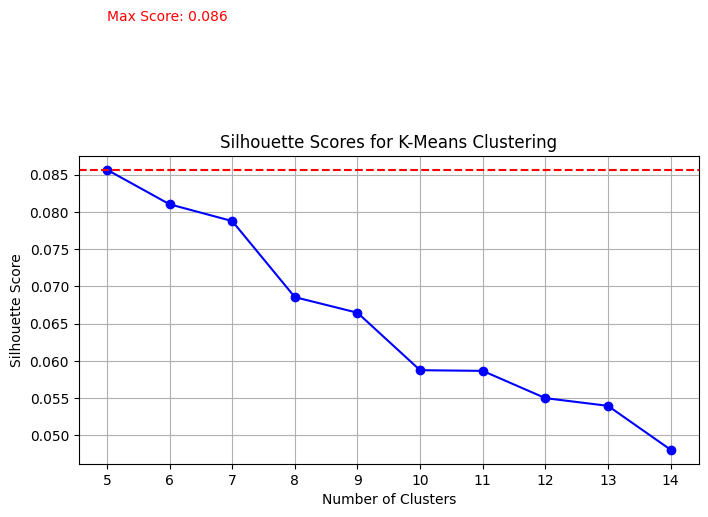

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(5, 15), silhouette_scores, marker='o', color='blue')

# Set the x-axis label, y-axis label, and title
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores for K-Means Clustering')

# Set the x-axis tick locations and labels
ax.set_xticks(range(5, 15))
ax.set_xticklabels(range(5, 15))

# Add a grid
ax.grid(True)

# Add a horizontal line at the maximum silhouette score
max_score = max(silhouette_scores)
ax.axhline(y=max_score, linestyle='--', color='red')
ax.text(5, max_score+0.02, f'Max Score: {max_score:.3f}', color='red')

# Show the plot
plt.show()

*   Based on the graph above, our top values come for clusters = [5,6,7,8,9,10]. We can further drill down into them and check



*   



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

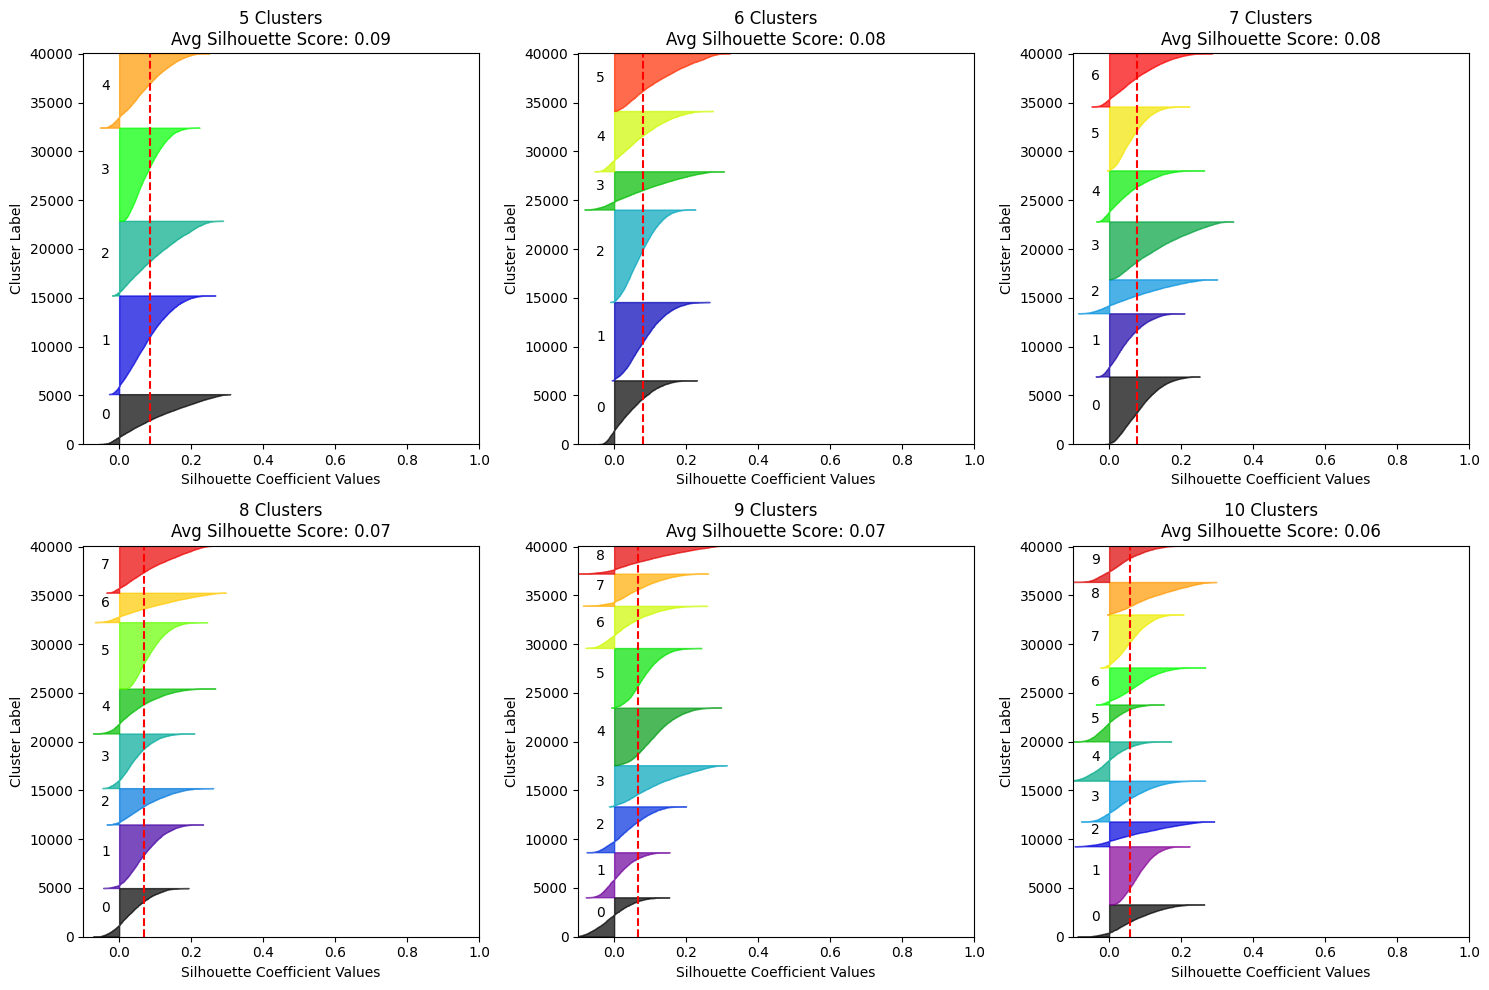

In [ ]:
# Set the range of cluster values
n_clusters_range = range(5, 11)

# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for i, n_clusters in enumerate(n_clusters_range):
    # Fit the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(trainX)

    # Compute the silhouette scores
    silhouette_avg = silhouette_score(trainX, labels)
    sample_silhouette_values = silhouette_samples(trainX, labels)

    # Plot the silhouette diagram
    ax = axes[i]
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(trainX) + (n_clusters + 1) * 10])

    y_lower = 10
    for j in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster j, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[labels == j]
        jth_cluster_silhouette_values.sort()

        size_jth_cluster = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_jth_cluster

        color = plt.cm.nipy_spectral(float(j) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, jth_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_jth_cluster, str(j))

        y_lower = y_upper + 10

    ax.set_title(f'{n_clusters} Clusters\nAvg Silhouette Score: {silhouette_avg:.2f}', fontsize=12)
    ax.set_xlabel('Silhouette Coefficient Values')
    ax.set_ylabel('Cluster Label')

    # Add a dashed line for the average silhouette score
    ax.axvline(x=silhouette_avg, linestyle='--', color='red')

plt.tight_layout()
plt.show()




*   So if we see all the graphs of different clusters, we find that with 9 clusters, the area of all clusters is pretty uniform as compared to others silhouetter diagrams, showing that it would work better for all classes. There isn't much difference between the silhouette score of the clusters and the individual figures arent very huge



---
Visualize the clusters
---

In [ ]:
trainX.shape

(40000, 160)

In [ ]:
pca = PCA(n_components=components)
# Fit the PCA model to the data
pca.fit(train_images)

PCA(n_components=160)

---
do you see similar clothing items in each cluster?
---

We investigate this by displaying a sample of each cluster

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


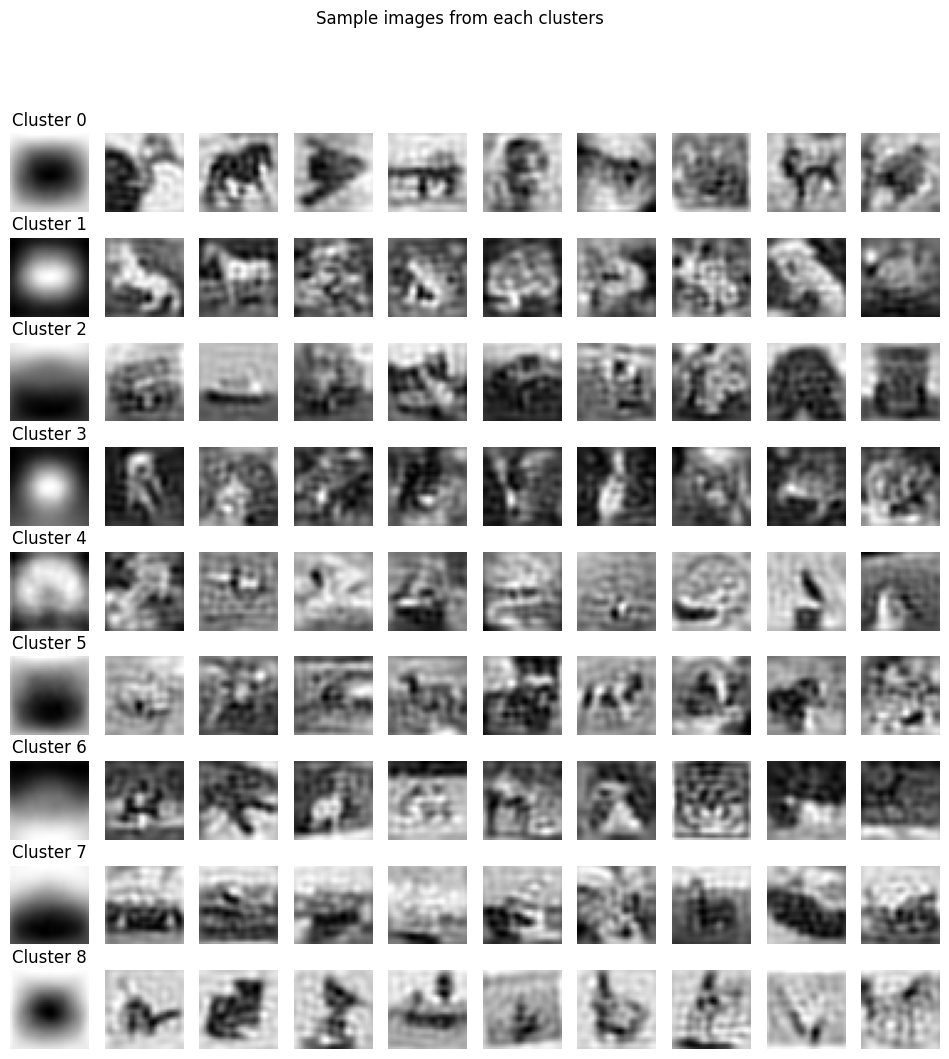

In [ ]:
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(trainX)

# Inverse transform the cluster centers to visualize them as images
centers_pca = kmeans.cluster_centers_
centers = pca.inverse_transform(centers_pca)
centers = centers.reshape(9, 32, 32)


# Inverse transform the data to assign each data point to its corresponding cluster
X_inv = pca.inverse_transform(trainX)
labels = kmeans.predict(trainX)

# Plot some sample images from each cluster
fig, ax = plt.subplots(nrows=9, ncols=10, figsize=(12, 12))
for i in range(9):
    indices = np.where(labels == i)[0]
    np.random.shuffle(indices)
    ax[i, 0].imshow(centers[i], cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 0].set_title("Cluster {}".format(i))
    for j in range(1, 10):
        ax[i, j].imshow(X_inv[indices[j-1]].reshape(32, 32), cmap='gray')
        ax[i, j].axis('off')
plt.suptitle("Sample images from each clusters")

plt.show()



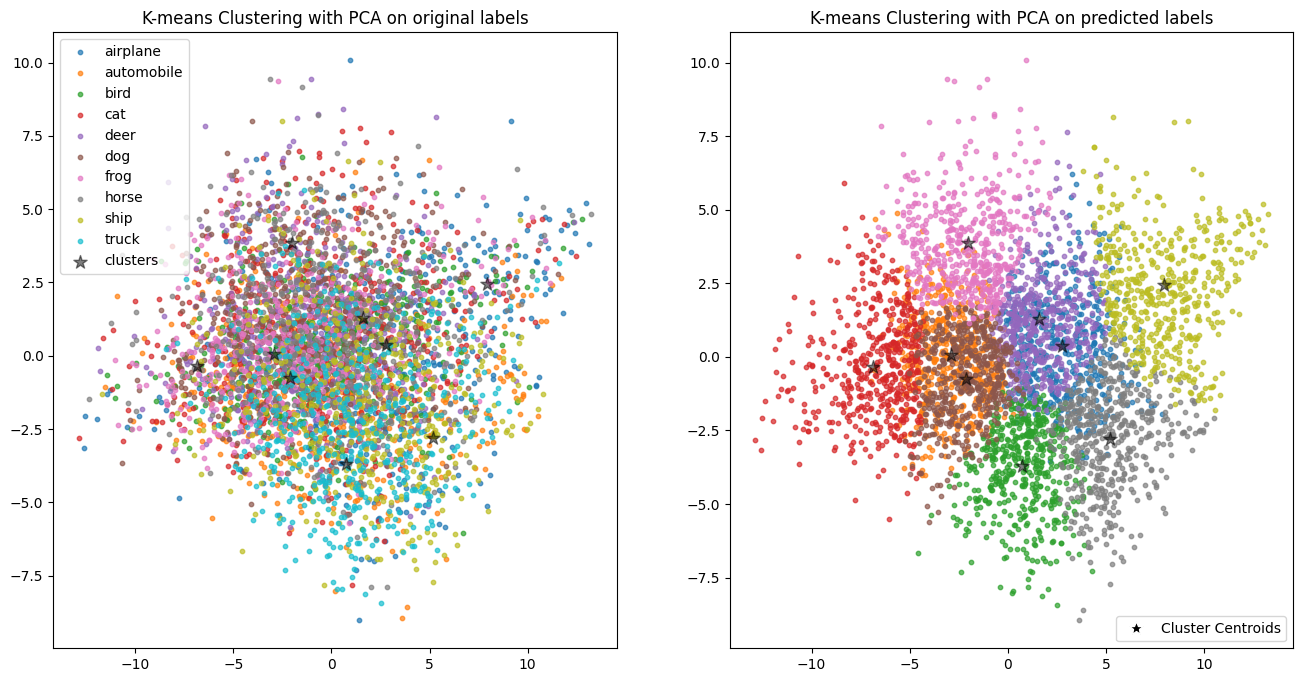

In [ ]:
color_map = plt.get_cmap('tab10')
# Plot a scatter plot of the clusters and their centroids
fig,ax = plt.subplots(1,2,figsize=(16, 8))

for i in range(10):
    indices = np.where(trainY == i)[0][:500] 
    ax[0].scatter(trainX[indices, 0],
                trainX[indices, 1],
                color=color_map(i),
                label=str(i),
                alpha=0.7, s = 10)

ax[0].scatter(centers_pca[:, 0], centers_pca[:, 1], marker='*', s=100, c='black', label='Centroids', alpha = 0.5)
ax[0].set_title("K-means Clustering with PCA on original labels")
ax[0].legend(list(class_names.values()) + ["clusters"])

for i in range(10):
    indices = np.where(labels == i)[0][:500] 
    ax[1].scatter(trainX[indices, 0],
                trainX[indices, 1],
                color=color_map(i),
                label=str(i),
                alpha=0.7, s = 10)

ax[1].scatter(centers_pca[:, 0], centers_pca[:, 1], marker='*', s=100, c='black', label='Centroids', alpha = 0.5)
ax[1].set_title("K-means Clustering with PCA on predicted labels")
ax[1].legend(loc='lower right', handles=[plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=10, label='Cluster Centroids')])
#ax[1].legend(["clusters"])

plt.show()

---
Do we see the same images in each cluster? 
---
No, we don't. The complexity of the dataset is such that no clear clusters can be formed. As evidenced in the above graph, the images are all interminged together and drawing discrete clusters from this is very difficult.

In [ ]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [ ]:
indices = np.random.choice(train_images.shape[0], 1000, replace=False)
tsne = TSNE(n_components=2)
train_tsne = train_images[indices]
X_tsne = tsne.fit_transform(train_tsne)
X_tsne_1000 = X_tsne
Y_tsne_1000 = train_labels[indices]

In [ ]:
X_tsne.shape

(1000, 2)

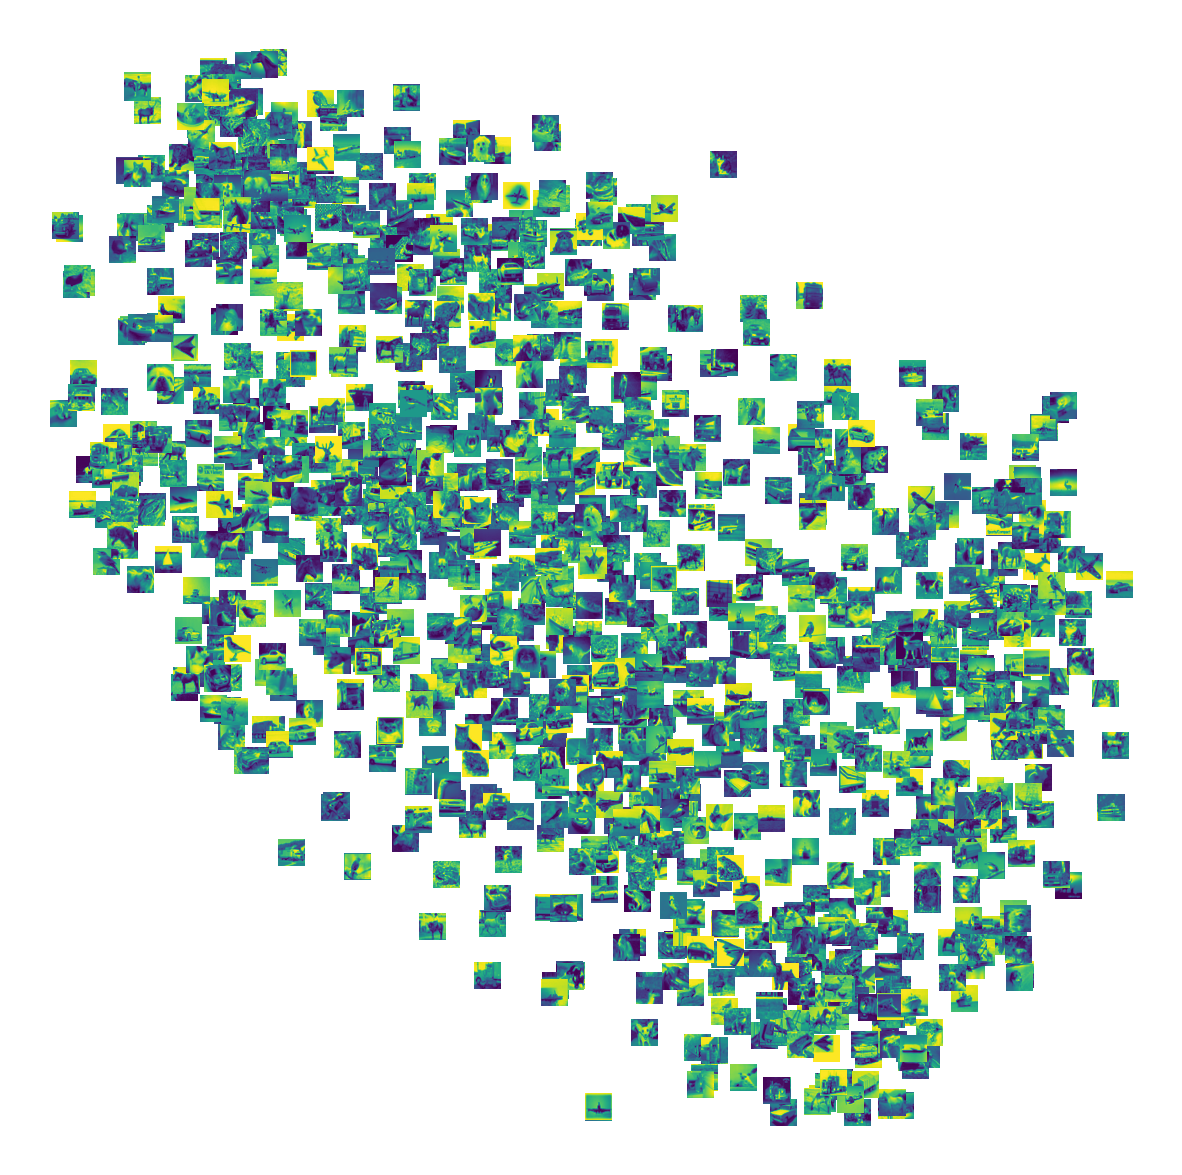

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X_tsne[:, 0], X_tsne[:,1])

for idx in range(len(X_tsne)):
    ab = AnnotationBbox(OffsetImage(train_images[idx].reshape(32, 32), zoom=0.6), (X_tsne[idx, 0], X_tsne[idx, 1]), frameon=False)
    ax.add_artist(ab)

plt.axis('off')
plt.show()



---


**Take 10000 samples of the training portion of the dataset and cluster the images using a Gaussian mixture model. To speed up the algorithm, use PCA to reduce the dimensionality of the dataset.Ensure that you have a good number of clusters using one of the techniques we discussed in
the class**


---

We use the BIC method to find the number of clusters


In [ ]:
trainX.shape, valX.shape

((40000, 160), (10000, 160))


*   valX is the compressed version of the total dataset



In [ ]:
valX.shape

(10000, 160)

In [ ]:
from sklearn.mixture import GaussianMixture

# Determine the optimal number of clusters using the Bayesian information criterion (BIC)
n_components = range(5, 15)
bic = []
for components in n_components:
    gmm = GaussianMixture(n_components=components, covariance_type='full', random_state=42)
    gmm.fit(valX)
    bic.append(gmm.bic(valX))

# Find the number of clusters with the lowest BIC score
optimal_n_components = n_components[np.argmin(bic)]

print("The optimal clusters are:", optimal_n_components)
# Fit the GMM model with the optimal number of clusters
gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='full', random_state=42)
gmm.fit(valX)
labels = gmm.predict(valX)




/usr/local/lib/python3.9/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


The optimal clusters are: 5


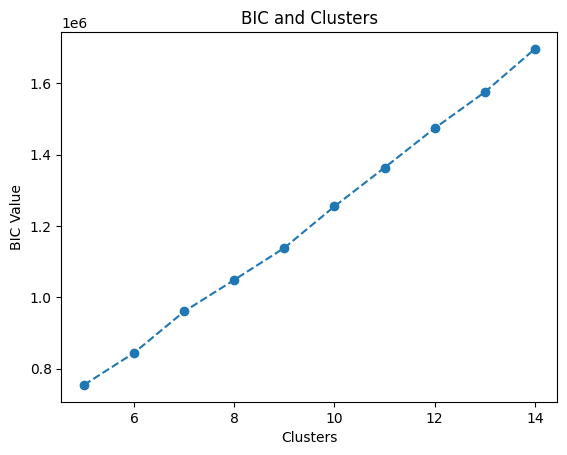

In [ ]:
plt.plot([i for i in range(5, 15)], bic, '--o')
plt.title("BIC and Clusters")
plt.xlabel("Clusters")
plt.ylabel("BIC Value")
plt.show()




---


**Visualize the clusters (you can show only a subset of images): do you see similar clothing items in each cluster**


---







*   few sample images from each cluster





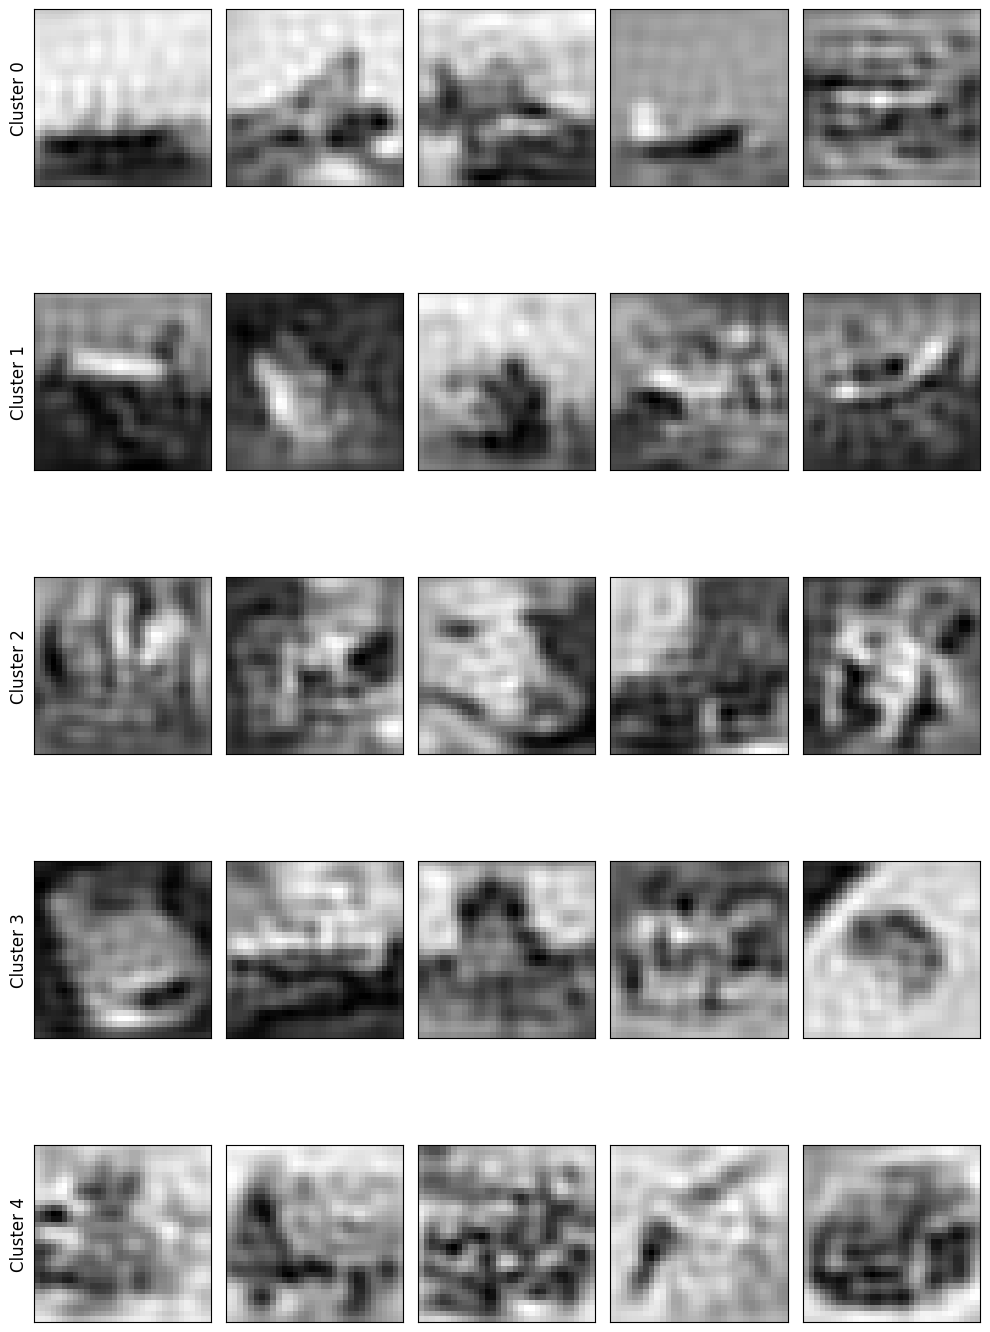

In [ ]:
# Plot

fig, axes = plt.subplots(nrows=optimal_n_components, ncols=5, figsize=(10, 15))
for i in range(optimal_n_components):
    idx = np.where(labels == i)[0][:5]
    for j, k in enumerate(idx):
        img = pca.inverse_transform(valX[k]).reshape(32, 32)
        ax = axes[i, j]
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    axes[i, 0].set_ylabel(f'Cluster {i}', fontsize=12)

plt.tight_layout()
plt.show()

We dont see much in the clusters here. Visual identification of the objects belonging to any cluster is difficult. But deeper inspection shows that diverse objects are being clustered together here. That is a failing of this algorithm here. This could be because of the complexity of the dataset. 

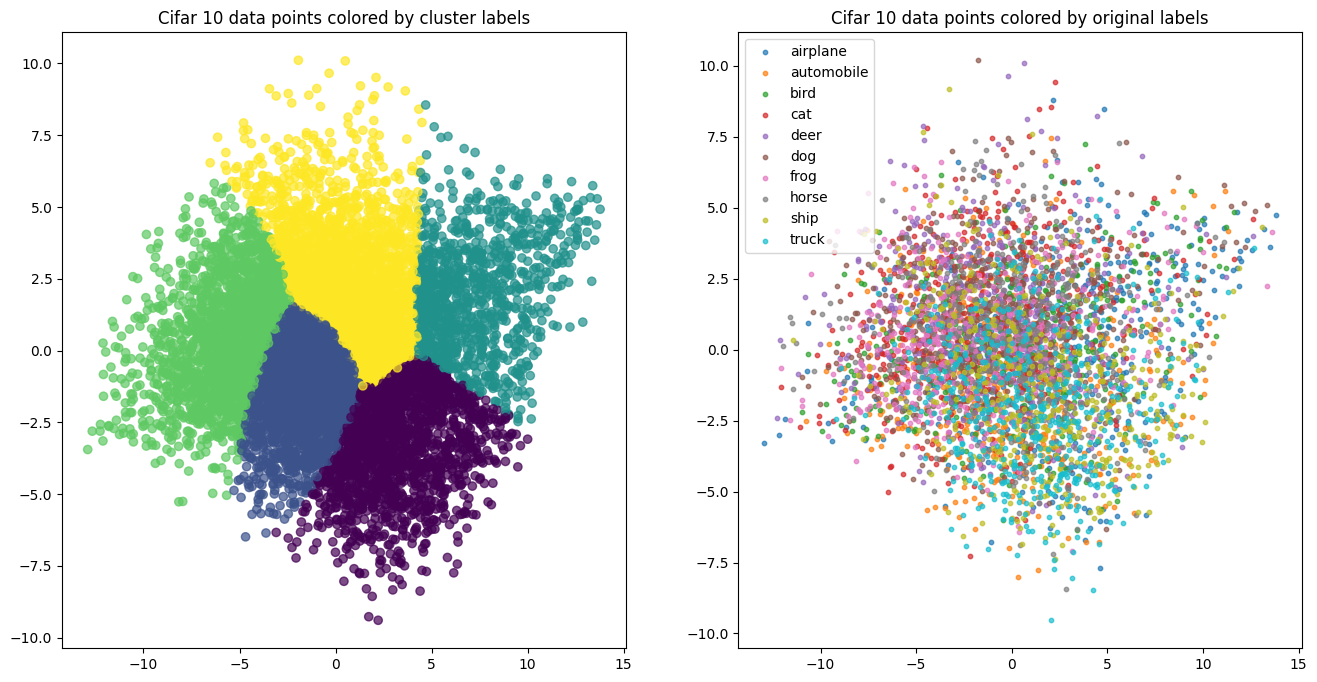

In [ ]:
pca = PCA(n_components=2, random_state=42)
valX_pca = pca.fit_transform(valX)
gmm = GaussianMixture(n_components=5)
gmm.fit(valX_pca)
labels = gmm.predict(valX_pca)

probs = gmm.predict_proba(valX_pca)
fig,ax = plt.subplots(1,2,figsize=(16, 8))
ax[0].scatter(valX_pca[:, 0], valX_pca[:, 1], c=labels, cmap='viridis', alpha= 0.7)
ax[0].set_title("Cifar 10 data points colored by cluster labels")


labels = valY
for i in range(10):
    indices = np.where(labels == i)[0][:500] 
    ax[1].scatter(valX[indices, 0],
                valX[indices, 1],
                color=color_map(i),
                label=str(i),
                alpha=0.7, s = 10)
ax[1].legend(class_names.values())
ax[1].set_title('Cifar 10 data points colored by original labels')
plt.show()

---
Use the model to generate 20 new clothing items (using the sample() method), and visualize them (since you used PCA, you will need to use its inverse_transform() method).

---

In [ ]:
gmm = GaussianMixture(n_components=optimal_n_components, covariance_type='full', random_state=42)
gmm.fit(valX)
generated_samples, _ = gmm.sample(n_samples=20)

In [ ]:
generated_samples.shape

(20, 160)

In [ ]:
generated_fashion = pca.inverse_transform(generated_samples)

In [ ]:
generated_fashion.shape

(20, 1024)

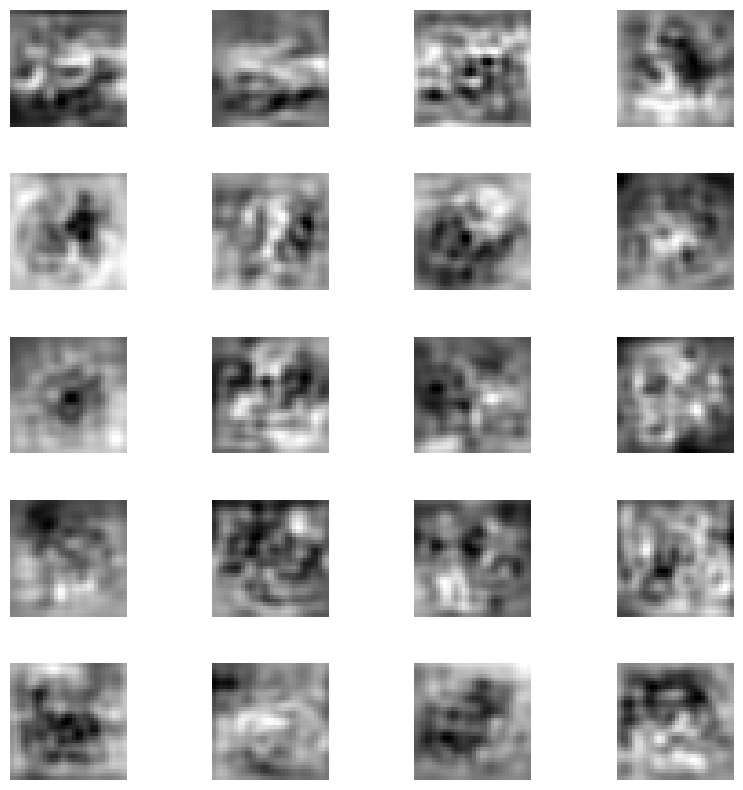

In [ ]:
def plot_images2(images, sz=32):
    fig, axes = plt.subplots(5, 4, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(20):
        axes[i].imshow(images[i].reshape(sz, sz), cmap="gray")
        axes[i].axis("off")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

plot_images2(generated_fashion)

Since clear identification of the clusters was not possible, the images generated above are also not clear and appear like a mishmash of a bunch of images. Hence, clear visual identification is not possible here


---


**Build a fully connected (dense) feedforward neural network with two hidden layers using Keras (within Tensorflow) and train it on the training images. First hidden layer should contain 200 neurons and second hidden layer should contain 50 neurons. The hidden layers should
have ReLU activation function. Train the network for 100 epochs. 


---

In [ ]:
# training as per the specifications

In [ ]:
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=trainX.shape[1:]),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy")

In [ ]:
trainX.shape

(40000, 160)

In [ ]:
modelfit=model.fit(trainX,trainY,epochs=100,validation_data=(valX,valY))

Epoch 1/100
1250/1250 [==============================] - 5s 3ms/step - loss: 1.8859 - val_loss: 1.7499
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6337 - val_loss: 1.6580
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5078 - val_loss: 1.6242
Epoch 4/100
1250/1250 [==============================] - 3s 3ms/step - loss: 1.4176 - val_loss: 1.6011
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3459 - val_loss: 1.6161
Epoch 6/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2855 - val_loss: 1.6285
Epoch 7/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.2304 - val_loss: 1.6596
Epoch 8/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1809 - val_loss: 1.6774
Epoch 9/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1383 - val_loss: 1.7004
Epoch 10/100
1250/1250 [==============================] - 3s 3ms/step - l

---

Plot training and validation loss and accuracy as a function of training epochs. 

---

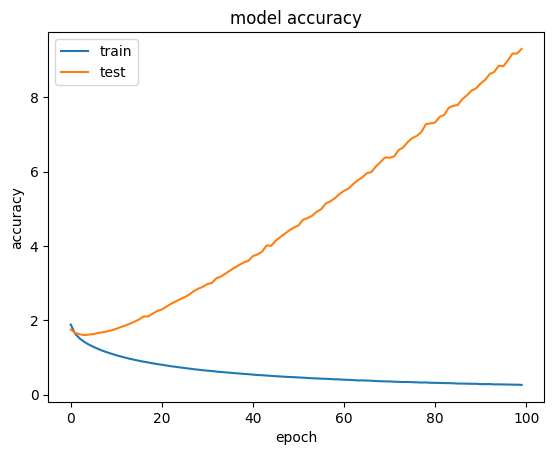

In [ ]:
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The model is most definitely overfitting based on this model

---
Try three different learning rates of your choice (make the plots for each learning rate). Run the network on the test portion of the dataset using best-performing learning rate and report loss and accuracy.
---

*   Selecting learning rates and using SGD and Adam optimizer to train model on all of them

In [ ]:

learningrates=learning_rates = [0.001, 0.01, 0.0001]


In [96]:

modelhistorySGD=[]
modelhistoryAdam=[]
for all in learningrates:

  model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=trainX.shape[1:]),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
  ])

  sgd = tf.keras.optimizers.SGD(learning_rate=all)
  model.compile(loss="sparse_categorical_crossentropy",optimizer=sgd)
  modelfit=model.fit(trainX,trainY,epochs=100,validation_data=(valX,valY))
  modelhistorySGD.append(modelfit.history)
  
for all in learningrates:

  model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=trainX.shape[1:]),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
  ])

  adams = tf.keras.optimizers.Adam(learning_rate=all)
  model.compile(loss="sparse_categorical_crossentropy",optimizer=adams)
  modelfit=model.fit(trainX,trainY,epochs=100,validation_data=(valX,valY))
  modelhistoryAdam.append(modelfit.history)

Epoch 1/100
1250/1250 [==============================] - 13s 8ms/step - loss: 2.2858 - val_loss: 2.2232
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 2.1885 - val_loss: 2.1599
Epoch 3/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.1377 - val_loss: 2.1205
Epoch 4/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.1024 - val_loss: 2.0918
Epoch 5/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.0747 - val_loss: 2.0684
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0513 - val_loss: 2.0482
Epoch 7/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.0304 - val_loss: 2.0300
Epoch 8/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.0116 - val_loss: 2.0134
Epoch 9/100
1250/1250 [==============================] - 3s 3ms/step - loss: 1.9948 - val_loss: 1.9989
Epoch 10/100
1250/1250 [==============================] - 4s 3ms/step - 

---
Plots for the above models
---

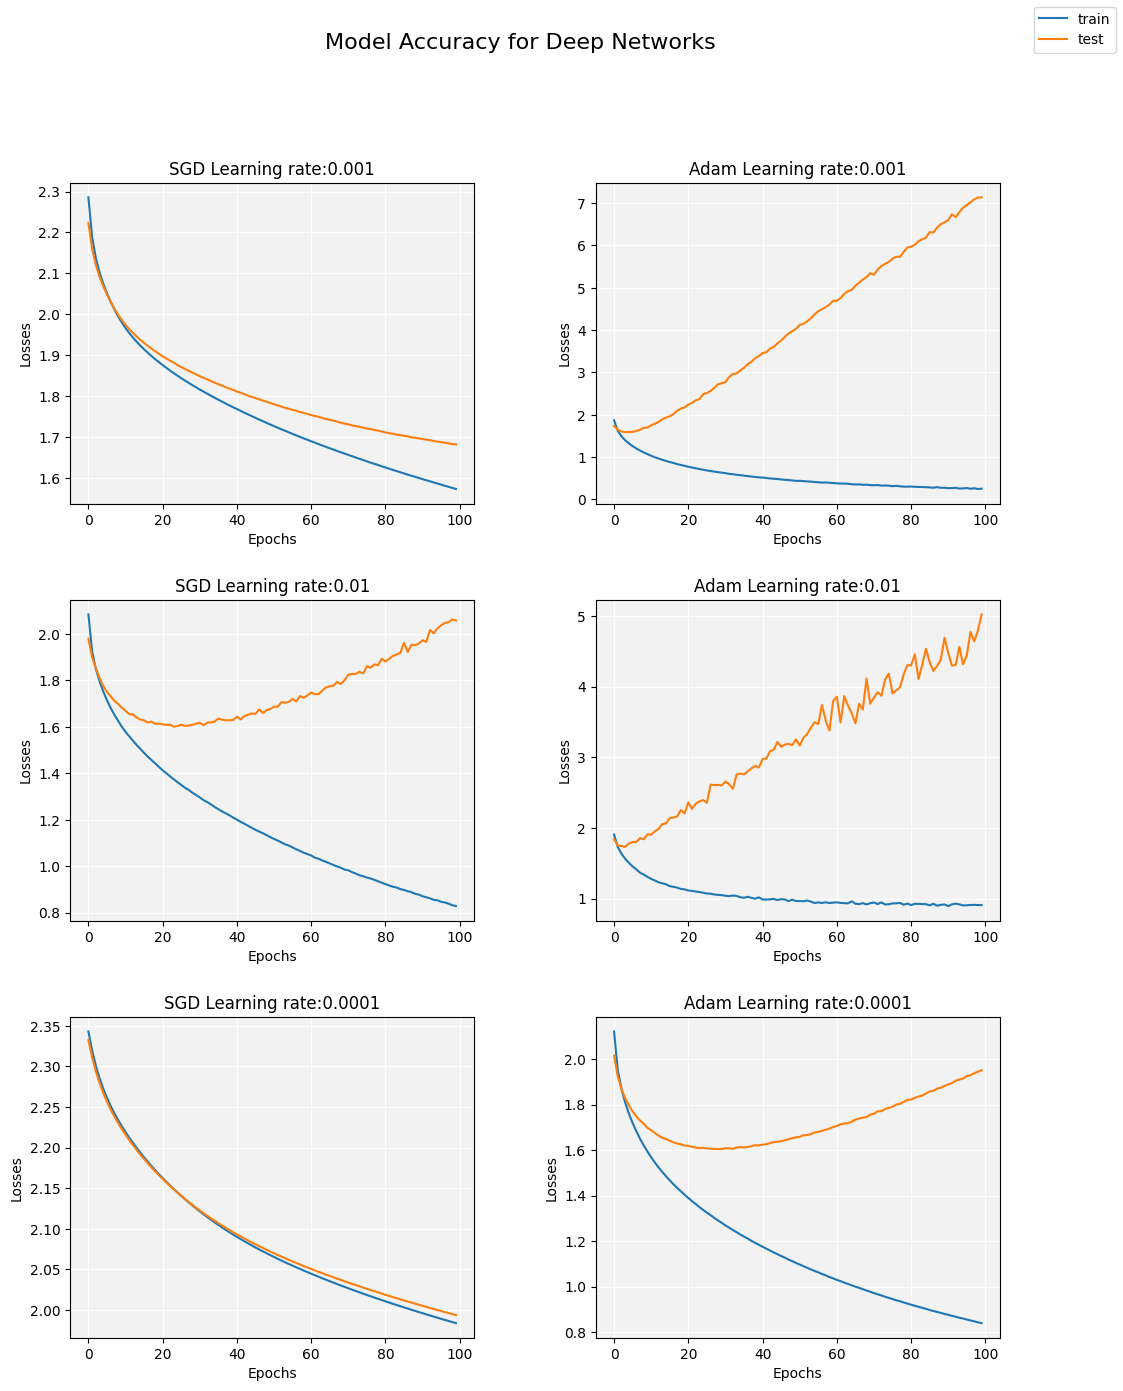

In [97]:
fig, ax = plt.subplots(3, 2, figsize=(12,15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

x=range(len(modelhistorySGD[0]['loss']))


ax[0, 0].plot(x, modelhistorySGD[0]['loss'])
ax[0, 0].plot(x, modelhistorySGD[0]['val_loss'])
ax[0, 0].title.set_text('SGD Learning rate:0.001')

ax[1, 0].plot(x, modelhistorySGD[1]['loss'])
ax[1, 0].plot(x, modelhistorySGD[1]['val_loss'])
ax[1, 0].title.set_text('SGD Learning rate:0.01')

ax[2, 0].plot(x, modelhistorySGD[2]['loss'])
ax[2, 0].plot(x, modelhistorySGD[2]['val_loss'])
ax[2, 0].title.set_text('SGD Learning rate:0.0001')

x=range(len(modelhistoryAdam[0]['loss']))

ax[0, 1].plot(x, modelhistoryAdam[0]['loss'])
ax[0, 1].plot(x, modelhistoryAdam[0]['val_loss'])
ax[0, 1].title.set_text('Adam Learning rate:0.001')

ax[1, 1].plot(x, modelhistoryAdam[1]['loss'])
ax[1, 1].plot(x, modelhistoryAdam[1]['val_loss'])
ax[1, 1].title.set_text('Adam Learning rate:0.01')

ax[2, 1].plot(x, modelhistoryAdam[2]['loss'])
ax[2, 1].plot(x, modelhistoryAdam[2]['val_loss'])
ax[2, 1].title.set_text('Adam Learning rate:0.0001')

for each in ax:
  for all in each:
    all.set_xlabel('Epochs')
    all.set_ylabel('Losses')
    all.patch.set_facecolor('grey')
    all.patch.set_alpha(0.1)
    all.grid(color='white', linestyle='-', linewidth=0.7)
fig.legend(['train', 'test'],loc='upper right')
fig.suptitle('Model Accuracy for Deep Networks', fontsize=16)
plt.show()

---
Run the network on the test portion of the dataset using best-performing learning rate and report loss and accuracy.
---

*   **The best-performing learning rate and report loss and accuracy can be seen with SGD optimizer for learning rate of 0.0001. SO we run this on test data**

In [98]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=trainX.shape[1:]),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(loss="sparse_categorical_crossentropy",optimizer=sgd, metrics=["accuracy"])
modelfit=model.fit(trainX,trainY,epochs=100,validation_data=(valX,valY))

Epoch 1/100
1250/1250 [==============================] - 12s 9ms/step - loss: 2.3892 - accuracy: 0.0731 - val_loss: 2.3687 - val_accuracy: 0.0786
Epoch 2/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.3588 - accuracy: 0.0831 - val_loss: 2.3418 - val_accuracy: 0.0900
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3354 - accuracy: 0.0954 - val_loss: 2.3205 - val_accuracy: 0.1011
Epoch 4/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.3165 - accuracy: 0.1074 - val_loss: 2.3030 - val_accuracy: 0.1146
Epoch 5/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.3007 - accuracy: 0.1189 - val_loss: 2.2881 - val_accuracy: 0.1239
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 2.2869 - accuracy: 0.1280 - val_loss: 2.2751 - val_accuracy: 0.1331
Epoch 7/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.2748 - accuracy: 0.1356 - val_loss: 2.2635 - val_a

In [100]:
evaluation = model.evaluate(test_pca_X, test_labels, return_dict=True)

313/313 [==============================] - 3s 10ms/step - loss: 1.9707 - accuracy: 0.3019


In [101]:
evaluation

{'loss': 1.9707306623458862, 'accuracy': 0.3018999993801117}

The loss and accuracy can be seen above.

---



**How many parameters does the network have? How many of those parameters are bias parameters?**

---

In [102]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 160)               0         
                                                                 
 dense_24 (Dense)            (None, 200)               32200     
                                                                 
 dense_25 (Dense)            (None, 50)                10050     
                                                                 
 dense_26 (Dense)            (None, 10)                510       
                                                                 
Total params: 42,760
Trainable params: 42,760
Non-trainable params: 0
_________________________________________________________________



*   42760 : total parameters. 
*   260 : bias parameters.
*   42500 : non bias parameters.



---
**Repeat everything from the previous step but make the hidden layers 
have linear activation functions.**


---

---
First hidden layer should contain 200 neurons and second hidden layer should contain 50 neurons. The hidden layers should have ReLU activation function. Train the network for 100 epochs.
---


In [30]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=trainX.shape[1:]),
    keras.layers.Dense(200, activation="linear"),
    keras.layers.Dense(50, activation="linear"),
    keras.layers.Dense(10, activation="softmax")
])

In [31]:
model.compile(loss="sparse_categorical_crossentropy")

In [32]:
modelfit=model.fit(trainX,trainY,epochs=100,validation_data=(valX,valY))

Epoch 1/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0771 - val_loss: 2.0442
Epoch 2/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0332 - val_loss: 2.0376
Epoch 3/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0230 - val_loss: 2.0354
Epoch 4/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0172 - val_loss: 2.0279
Epoch 5/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.0134 - val_loss: 2.0278
Epoch 6/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0106 - val_loss: 2.0241
Epoch 7/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0080 - val_loss: 2.0277
Epoch 8/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0080 - val_loss: 2.0233
Epoch 9/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0067 - val_loss: 2.0255
Epoch 10/100
1250/1250 [==============================] - 5s 4ms/step - l

---
Plot training and validation loss and accuracy as a function of training epochs.
---

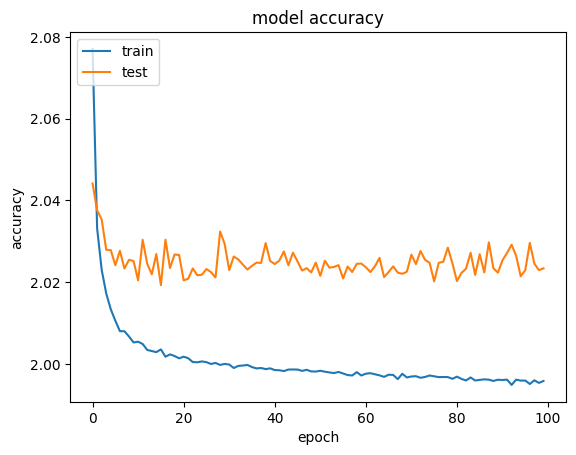

In [33]:
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---
Try three different learning rates of your choice
---


*   Selecting learning rates and using SGD and Adam optimizer to train model on all of them

In [34]:
learningrates=learning_rates = [0.0001,0.000001,0.0000001]

In [35]:
modelhistorySGD=[]
modelhistoryAdam=[]
for all in learningrates:

  model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=trainX.shape[1:]),
    keras.layers.Dense(200),
    keras.layers.Dense(50),
    keras.layers.Dense(10, activation="softmax")
  ])

  sgd = tf.keras.optimizers.SGD(learning_rate=all)
  model2.compile(loss="sparse_categorical_crossentropy",optimizer=sgd)
  model2fit=model2.fit(trainX,trainY,epochs=100,validation_data=(valX,valY))
  modelhistorySGD.append(model2fit.history)
  
for all in learningrates:

  model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=trainX.shape[1:]),
    keras.layers.Dense(200),
    keras.layers.Dense(50),
    keras.layers.Dense(10, activation="softmax")
  ])

  adams = tf.keras.optimizers.Adam(learning_rate=all)
  model2.compile(loss="sparse_categorical_crossentropy",optimizer=adams)
  model2fit=model2.fit(trainX,trainY,epochs=100,validation_data=(valX,valY))
  modelhistoryAdam.append(model2fit.history)

Epoch 1/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.6236 - val_loss: 2.4649
Epoch 2/100
1250/1250 [==============================] - 2s 2ms/step - loss: 2.3973 - val_loss: 2.3391
Epoch 3/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.3092 - val_loss: 2.2798
Epoch 4/100
1250/1250 [==============================] - 2s 2ms/step - loss: 2.2624 - val_loss: 2.2446
Epoch 5/100
1250/1250 [==============================] - 2s 2ms/step - loss: 2.2322 - val_loss: 2.2202
Epoch 6/100
1250/1250 [==============================] - 2s 2ms/step - loss: 2.2104 - val_loss: 2.2019
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.1935 - val_loss: 2.1873
Epoch 8/100
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1797 - val_loss: 2.1751
Epoch 9/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.1680 - val_loss: 2.1647
Epoch 10/100
1250/1250 [==============================] - 3s 2ms/step - l

---
Plots for the above models
---

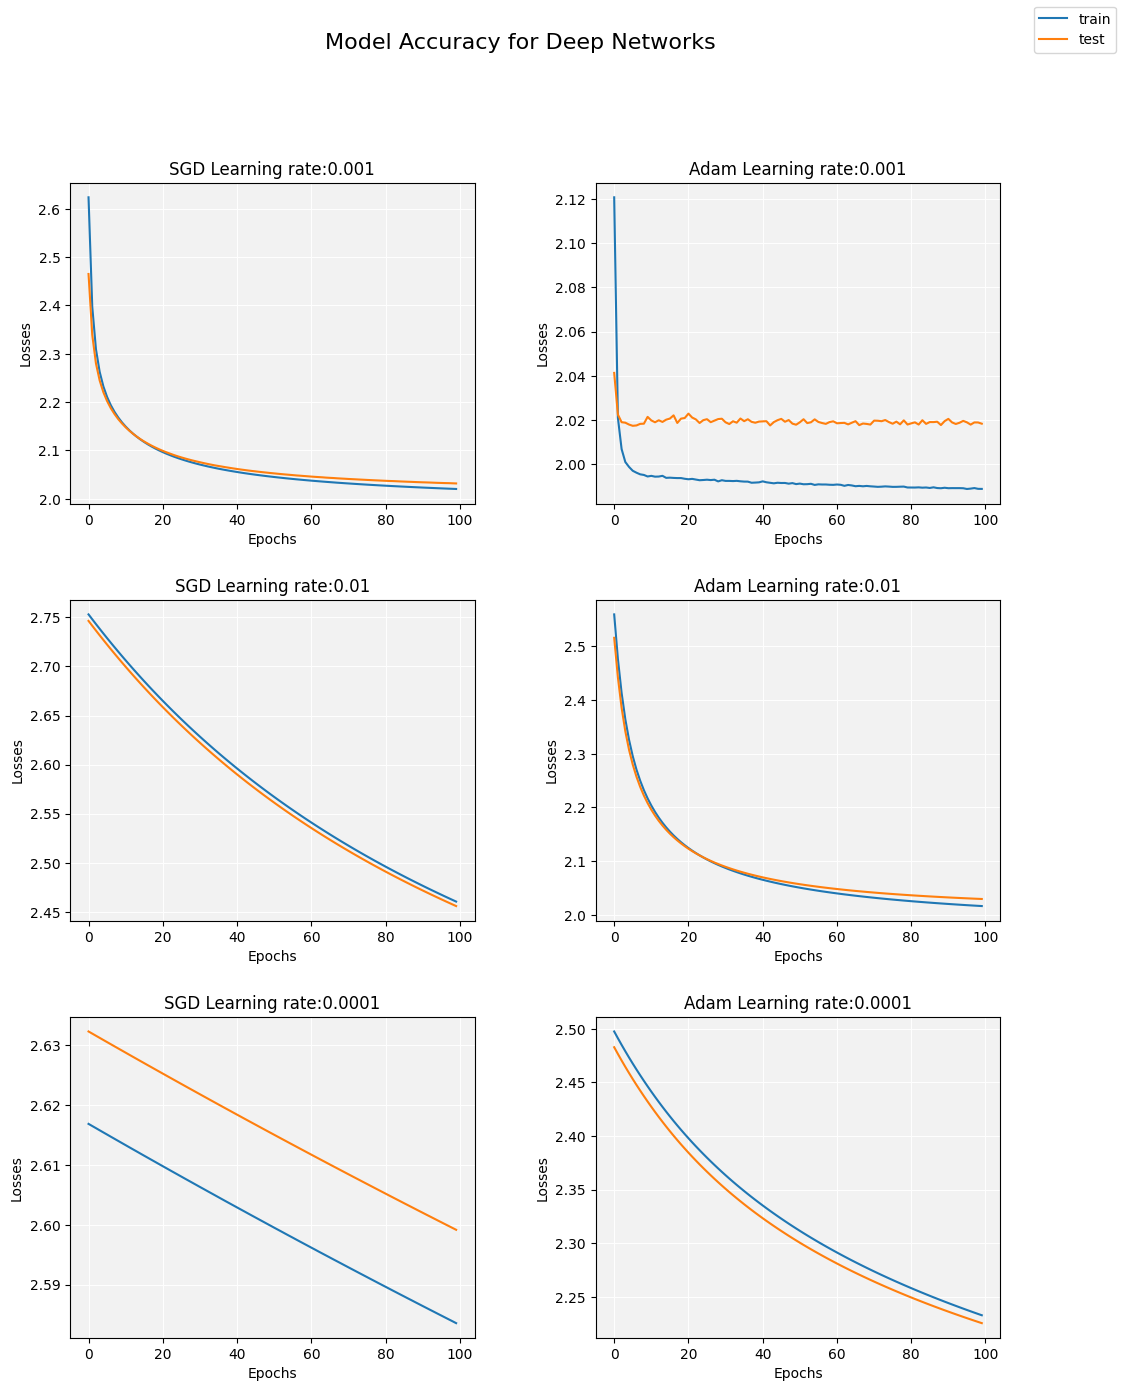

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(12,15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

x=range(len(modelhistorySGD[0]['loss']))


ax[0, 0].plot(x, modelhistorySGD[0]['loss'])
ax[0, 0].plot(x, modelhistorySGD[0]['val_loss'])
ax[0, 0].title.set_text('SGD Learning rate:0.001')

ax[1, 0].plot(x, modelhistorySGD[1]['loss'])
ax[1, 0].plot(x, modelhistorySGD[1]['val_loss'])
ax[1, 0].title.set_text('SGD Learning rate:0.01')

ax[2, 0].plot(x, modelhistorySGD[2]['loss'])
ax[2, 0].plot(x, modelhistorySGD[2]['val_loss'])
ax[2, 0].title.set_text('SGD Learning rate:0.0001')

x=range(len(modelhistoryAdam[0]['loss']))

ax[0, 1].plot(x, modelhistoryAdam[0]['loss'])
ax[0, 1].plot(x, modelhistoryAdam[0]['val_loss'])
ax[0, 1].title.set_text('Adam Learning rate:0.001')

ax[1, 1].plot(x, modelhistoryAdam[1]['loss'])
ax[1, 1].plot(x, modelhistoryAdam[1]['val_loss'])
ax[1, 1].title.set_text('Adam Learning rate:0.01')

ax[2, 1].plot(x, modelhistoryAdam[2]['loss'])
ax[2, 1].plot(x, modelhistoryAdam[2]['val_loss'])
ax[2, 1].title.set_text('Adam Learning rate:0.0001')

for each in ax:
  for all in each:
    all.set_xlabel('Epochs')
    all.set_ylabel('Losses')
    all.patch.set_facecolor('grey')
    all.patch.set_alpha(0.1)
    all.grid(color='white', linestyle='-', linewidth=0.7)
fig.legend(['train', 'test'],loc='upper right')
fig.suptitle('Model Accuracy for Deep Networks', fontsize=16)
plt.show()

---
Run the network on the test portion of the dataset using best-performing learning rate and report loss and accuracy
---

The best performance is observed on SGD with learning rate 0.001

In [37]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=trainX.shape[1:]),
    keras.layers.Dense(200, activation="linear"),
    keras.layers.Dense(50, activation="linear"),
    keras.layers.Dense(10, activation="softmax")
])

sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy",optimizer=sgd, metrics=["accuracy"])
modelfit=model.fit(trainX,trainY,epochs=100,validation_data=(valX,valY))

Epoch 1/100
1250/1250 [==============================] - 6s 4ms/step - loss: 2.2270 - accuracy: 0.2010 - val_loss: 2.1304 - val_accuracy: 0.2385
Epoch 2/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.1054 - accuracy: 0.2493 - val_loss: 2.0893 - val_accuracy: 0.2539
Epoch 3/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0753 - accuracy: 0.2634 - val_loss: 2.0706 - val_accuracy: 0.2659
Epoch 4/100
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0592 - accuracy: 0.2727 - val_loss: 2.0587 - val_accuracy: 0.2744
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0485 - accuracy: 0.2782 - val_loss: 2.0511 - val_accuracy: 0.2769
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0409 - accuracy: 0.2825 - val_loss: 2.0454 - val_accuracy: 0.2832
Epoch 7/100
1250/1250 [==============================] - 3s 3ms/step - loss: 2.0352 - accuracy: 0.2861 - val_loss: 2.0405 - val_ac

In [39]:
evaluation = model.evaluate(test_pca_X, test_labels, return_dict=True)

313/313 [==============================] - 1s 2ms/step - loss: 2.0154 - accuracy: 0.3047


In [40]:
evaluation

{'loss': 2.0153613090515137, 'accuracy': 0.30469998717308044}

---
How many parameters does the network have? How many of those parameters are bias parameters?
---

In [41]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 160)               0         
                                                                 
 dense_21 (Dense)            (None, 200)               32200     
                                                                 
 dense_22 (Dense)            (None, 50)                10050     
                                                                 
 dense_23 (Dense)            (None, 10)                510       
                                                                 
Total params: 42,760
Trainable params: 42,760
Non-trainable params: 0
_________________________________________________________________


*   42760 : total parameters. 
*   260 : bias parameters.
*   42500 : non bias parameters.

---
Discuss the results of Relu vs Linear model
---

Both models are neural networks designed to classify images from the CIFAR-10 dataset, which consists of 10 classes of images such as airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

The first model has two hidden layers with 200 and 50 neurons respectively, and uses the ReLU activation function. The second model has the same architecture but uses the linear activation function instead.

The models were trained with stochastic gradient descent (SGD) as the optimizer and the sparse categorical cross-entropy as the loss function. The learning rate used in the first model is 0.0001, while the second model uses 0.001.

The first model achieved an accuracy of 0.3019 on the validation set after 100 epochs, while the second model achieved an accuracy of 0.3047.

The accuracy achieved by both models is quite low, indicating that the models are not very effective at classifying images from the CIFAR-10 dataset. There are several reasons why this might be the case, such as the models being too simple or not having enough training data.

It is also worth noting that the second model's use of the linear activation function may have contributed to its slightly better performance, as the ReLU function can sometimes cause the gradients to vanish, which can make it more difficult to train deep neural networks. However, using the linear activation function in the hidden layers is not a common practice, and other activation functions such as the sigmoid or tanh functions may be more suitable.

The CIFAR-10 dataset is a challenging dataset for image classification, with low-resolution images that are only 32x32 pixels in size. This means that the models need to be able to extract useful features from the images despite the limited amount of information available.
